In [34]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
# --- Theme Configuration ---
# Feel free to experiment with these colors!
BACKGROUND_COLOR = '#2c3e50'  # Dark slate blue
AXES_FACE_COLOR = '#34495e'   # Slightly lighter slate blue
TEXT_COLOR = '#ecf0f1'       # Light silver/off-white
ACCENT_COLOR_1 = '#e74c3c'     # Bright red
ACCENT_COLOR_2 = '#3498db'     # Bright blue
ACCENT_COLOR_3 = '#f1c40f'     # Bright yellow
GRID_COLOR = '#7f8c8d'       # Muted gray for grid
SPINE_COLOR = '#95a5a6'      # Slightly lighter gray for spines
LEGEND_FACE_COLOR = '#34495e'
LEGEND_EDGE_COLOR = '#ecf0f1'

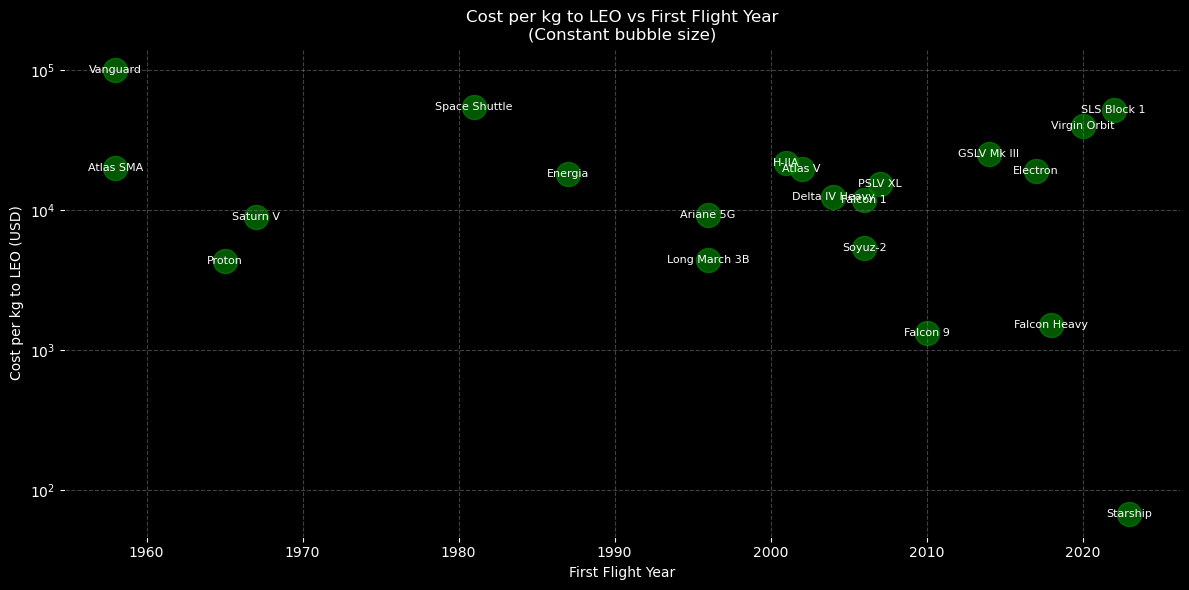

In [2]:
import matplotlib.pyplot as plt

# Data without N1, constant bubble size
rockets = [
    "Vanguard", "Atlas SMA", "Saturn V", "Space Shuttle", "Energia",
    "Proton", "Soyuz-2", "Falcon 1", "Delta IV Heavy", "Atlas V", "Ariane 5G",
    "Long March 3B", "PSLV XL", "H-IIA", "GSLV Mk III", "Electron", 
    "Virgin Orbit", "Falcon 9", "Falcon Heavy", "SLS Block 1", "Starship"
]

first_flight = [
    1958, 1958, 1967, 1981, 1987,
    1965, 2006, 2006, 2004, 2002, 1996,
    1996, 2007, 2001, 2014, 2017, 2020,
    2010, 2018, 2022, 2023
]

cost_per_kg = [
    100000, 20000, 8900, 54500, 18000,
    4320, 5333, 11754, 12340, 19500, 9167,
    4412, 15450, 21500, 25000, 19039, 40000,
    1320, 1500, 52100, 67
]

# Create bubble chart with constant size
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

constant_size = 300  # constant bubble size for all

ax.scatter(first_flight, cost_per_kg, s=constant_size, color='green', alpha=0.7)

# Centered annotations
for x, y, label in zip(first_flight, cost_per_kg, rockets):
    ax.text(x, y, label, fontsize=8, ha='center', va='center', color='white')

# Styling
ax.set_xlabel("First Flight Year", color='white')
ax.set_ylabel("Cost per kg to LEO (USD)", color='white')
ax.set_title("Cost per kg to LEO vs First Flight Year\n(Constant bubble size)", color='white')
ax.set_yscale('log')
ax.grid(True, color='gray', linestyle='--', alpha=0.5)
ax.tick_params(colors='white')

plt.tight_layout()
plt.show()


In [28]:

# performance = { 'Rocket': [wet mass (kg), dry mass (kg), vacuum Isp (s)] }
performance = {
    # [wet_mass_kg, dry_mass_kg, Isp_s, LEO_payload_kg]
    'Atlas V 551':              [23077, 2247, 449.7,   18850],
    'Falcon 9 expended':        [111500, 4000, 348,    22800],   # fully‑fuelled second stage
    'Falcon Heavy expended':    [111500, 4000, 348,    63800],
    'Delta IV Heavy':           [30700,  3480, 465.5,  28790],
    'SLS Block 1B':             [143000,  14000, 460, 105000],
    'Starship refuelled in LEO':[1300000,120000,380,  1450000],
    'Starship refuelled in HEO':[1300000,120000,380,  1450000],
    'Stripped Starship refuelled in HEO':[1300000,80000,380,  1450000],
}
#all assume starting in orbit with periapsis of 200km, but have some DV penalty/bonus from use of upper stage to reach LEO/HEO Starship & SLS bonus

    




Need to calculate the payload mass of various rockets as a function of C3. C3 is the energy given as:
$$
\frac{C_3}{2}=\frac{v^2}{2}-\frac{\mu}{r}
$$
This is only positive for objects on escape velocity trajectories. Once we know the DV of the spacecraft, it is easy to calculate this number numerically starting from HEO (eg SLS or Starship) or analytically from LEO (even easier). The issue is that for all vehicles that do not utilize in orbit refuelling, the LEO/HEO DV is a function of payload mass, and this is not publically avaliable info. We can make a first pass assuming that the second stage reaches orbit with propellant roughly equal to the vehicles max LEO payload minus the actual payload mass. 

<!-- We can make a first pass assuming constant DV to reach orbit (not a terrible assumption since all listed vehicles have reasonably high TWR, so gravity losses are reduced) -->

The only major problem is SLS as LEO payload > 2nd stage prop mass for block 1. I suppose I could just do B1B. 


In [53]:
#Light DV calc
isp = 380.5 #348 mvac, 380 rvac, 421 j2, 450.5 Rl10
payload = 122000
dry_mass = 122050#dry mass of upper stage not including payload
max_payload_leo = 1500000
dv = 9.81*isp*np.log((max_payload_leo+dry_mass)/(payload+dry_mass))
print(f"{dv}m/s")


7070.015526065858m/s


(0.0, 120000.0)

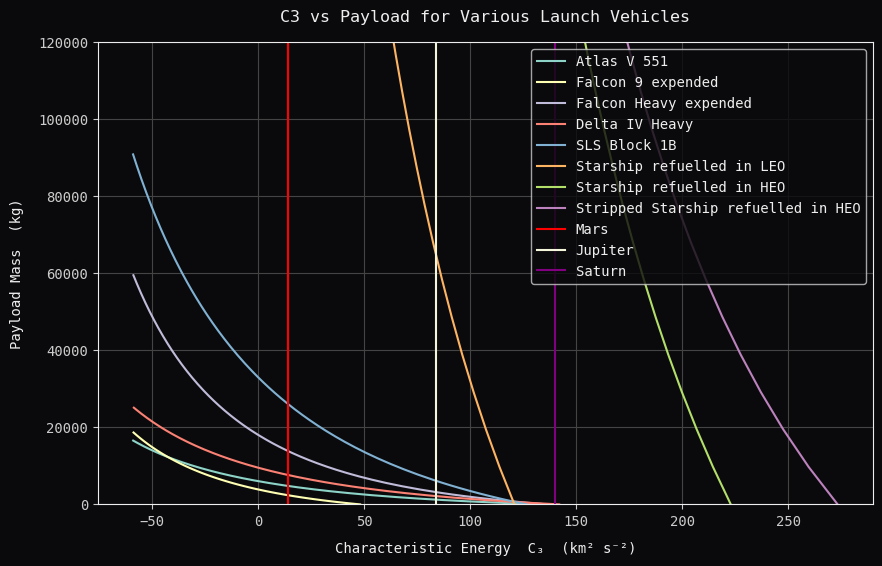

In [50]:
g0 = 9.80665  # m/s^2
v_leo = 7780  # m/s (circular velocity at ~200 km)
v_escape = 10930  # m/s (escape velocity at same altitude)

fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('dark_background') # Start with a dark base

# ----------  Retro‑Sci‑Fi Matplotlib Theme  ----------
plt.rcParams.update({
    'figure.facecolor': '#0A0A0C',
    'axes.facecolor':   '#0A0A0C',
    'axes.edgecolor':   '#EEEEEE',
    'axes.labelcolor':  '#EEEEEE',
    'text.color':       '#EEEEEE',
    'xtick.color':      '#CCCCCC',
    'ytick.color':      '#CCCCCC',
    'grid.color':       '#444444',
    'font.family':      'monospace',
    'axes.titlepad':    15,
})

for lv, (wet_mass, dry_mass, isp, leo_cap) in performance.items():
    prop_capacity = wet_mass - dry_mass
    # sample 150 points between a small payload (1 kg) and the LEO capability
    payloads = np.linspace(1, leo_cap, 150)
    c3_vals = []
    valid_payloads = []
    for p in payloads:
        available_prop = leo_cap - p - dry_mass
        # cap by tank capacity and ignore negative available propellant
        if available_prop <= 0:
            continue
        available_prop = min(available_prop, prop_capacity)
        delta_v = 0.87*isp * g0 * np.log((available_prop+dry_mass+p)/ (dry_mass + p))
        if lv == 'Starship refuelled in HEO' or lv == 'Stripped Starship refuelled in HEO':
            delta_v += 3000
        c3 = (v_leo + delta_v)**2 - v_escape**2  # m^2/s^2
        c3_vals.append(c3 / 1e6)  # convert to km^2/s^2
        valid_payloads.append(p)
    if c3_vals:
        ax.plot(c3_vals, valid_payloads, label=lv)



# Axis labels and title with retro flavour
ax.set_xlabel('Characteristic Energy  C₃  (km² s⁻²)', labelpad=10)
ax.set_ylabel('Payload Mass  (kg)', labelpad=10)
plt.title('C3 vs Payload for Various Launch Vehicles')
ax.grid(True)
#ax.tight_layout()
plt.axvline(x = 14, color = 'red', label = 'Mars')
plt.axvline(x = 84, color = 'beige', label = 'Jupiter')
plt.axvline(x = 140, color = 'purple', label = 'Saturn')
ax.legend(loc='upper right')

plt.ylim(top = 120000,bottom = 0)
# plt.show()